In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import pygalmesh
import fenics as fe
import torch
import torch.nn.functional as F
import torch_fenics

import sys
sys.path.append('..')
import project

In [3]:
%autoreload
case = project.imaging.Emory4DCT('../data/Emory-4DCT')[1]
case.load_niftis()
case.load_masks(roi='lung_regions')
case.load_displacements(moving_phase=10, relative=True)
case.load_meshes(roi='lung_regions', mesh_radius=10)

Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T60.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T70.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T80.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T90.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T00/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T10/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T20/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T30/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T40/lung_regions.nii.gz


CT


<IPython.core.display.Javascript object>


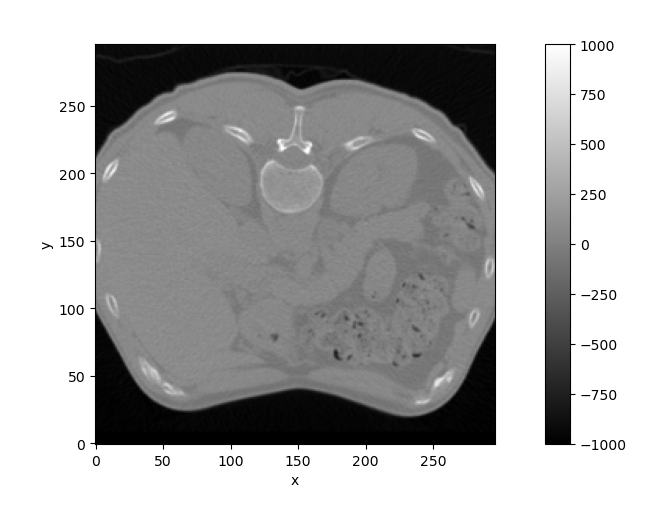

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

torch.Size([1, 256, 256, 94]) torch.Size([1, 256, 256, 94])


In [5]:
project.visual.XArrayViewer(case.anat)

anat_image = torch.as_tensor(case.anat.sel(phase=0).values).unsqueeze(0).cuda()
mask = torch.as_tensor(case.mask.sel(phase=0, roi='lung_regions').values > 0).unsqueeze(0).cuda()
print(anat_image.shape, mask.shape)

In [7]:
mesh = case.meshes[0]
S = fe.FunctionSpace(mesh, 'P', 1)

points = torch.as_tensor(S.tabulate_dof_coordinates()).cuda()
points.shape

torch.Size([23529, 3])

In [15]:
%%time

def compute_point_radius(points, resolution):
    min_radius = np.linalg.norm(resolution) / 2
    distance = torch.norm(points[:,None,:] - points[None,:,:], dim=-1)
    distance[distance == 0] = 1e3
    distance[distance < min_radius] = min_radius
    return distance.min(dim=-1, keepdims=True).values

radius = compute_point_radius(points, case.resolution)

CPU times: user 42.4 ms, sys: 114 ms, total: 156 ms
Wall time: 4.11 s


In [27]:
kernel_size = (radius / torch.as_tensor(case.resolution)).floor().long().max()
kernel_size

tensor(12)

In [16]:
%%time

def interpolate_image(image, mask, resolution, points, kernel_radius, kernel_size=None):
    '''
    Image interpolation method that takes a weighted sum
    of the image values in the neighborhood of each point.

    Args:
        image: (C, X, Y, Z) image tensor
        mask: (C, X, Y, Z) mask tensor
        resolution: image resolution (float)
        points: (N, 3) sampling points
        kernel_radius: kernel shape parameter (N,)
    '''
    C, X, Y, Z = image.shape
    N, D = points.shape
    assert D == 3, 'points must be 3D'
    
    zeros = torch.zeros(D, device=image.device)
    shape = torch.as_tensor([X, Y, Z], device=image.device)
    resolution = torch.as_tensor(resolution, device=image.device) 

    if kernel_size is None:
        kernel_size = (kernel_radius / resolution).floor().long().max()

    x_offsets = torch.arange(-kernel_size, kernel_size, device=image.device) + 1
    y_offsets = torch.arange(-kernel_size, kernel_size, device=image.device) + 1
    z_offsets = torch.arange(-kernel_size, kernel_size, device=image.device) + 1
    
    offsets = torch.meshgrid(x_offsets, y_offsets, z_offsets, indexing='ij')
    offsets = torch.stack(offsets, dim=-1).reshape(-1, D) # (K, D)

    nearest_voxel = (points / resolution.unsqueeze(0)).floor().long() # (N, D)
    
    neighbor_voxels = nearest_voxel.unsqueeze(1) + offsets.unsqueeze(0) # (N, K, D)
    neighbor_voxels = neighbor_voxels.clamp(min=zeros, max=(shape - 1)).long()
    
    neighbor_values = image[
        :,
        neighbor_voxels[:,:,0],
        neighbor_voxels[:,:,1],
        neighbor_voxels[:,:,2],
    ].permute(1,2,0) # (N, K, C)

    neighbor_mask = mask[
        0,
        neighbor_voxels[:,:,0],
        neighbor_voxels[:,:,1],
        neighbor_voxels[:,:,2],
    ] # (N, K)
  
    neighbor_points = neighbor_voxels * resolution.unsqueeze(0).unsqueeze(0) # (N, K, D)
    
    displacement = (neighbor_points - points.unsqueeze(1)) # (N, K, D)
    distance = torch.norm(displacement, dim=-1) # (N, K)
    
    #weights = torch.clamp(1 - torch.abs(distance / kernel_radius), 0) # (N, K)
    kernel_sigma = kernel_radius / 2
    weights = torch.exp(-(distance / kernel_sigma)**2) # (N, K)
    weights = weights * neighbor_mask
    
    weighted_sum = (weights.unsqueeze(-1) * neighbor_values).sum(dim=1) # (N, C)
    total_weight = weights.sum(dim=-1, keepdims=True) + 1e-8 # (N, 1)
    assert (total_weight > 0).all(), 'zero total weight'
    
    interpolated_values = weighted_sum / total_weight # (N, C)

    return interpolated_values

anat_dofs = interpolate_image(anat_image, mask, case.resolution, points, radius, kernel_size=1)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [40]:
%%time

def image_to_dofs(image, resolution, V, kernel_radius, kernel_size=None):
    '''
    Args:
        image: (C, X, Y, Z) torch.Tensor
        V: fenics.FunctionSpace
            defined on (N, D) coordinates
    Returns:
        dofs: (N, C) torch.Tensor
    '''
    C, X, Y, Z = image.shape
    
    points = V.tabulate_dof_coordinates()
    if V.num_sub_spaces() > 0:
        points = points[::V.num_sub_spaces(),:]
    
    N, D = points.shape

    points = torch.as_tensor(points, dtype=image.dtype, device=image.device)

    values = interpolate_image(
        image=image,
        points=points,
        resolution=resolution,
        kernel_radius=kernel_radius,
        kernel_size=kernel_size,
    ).double()

    if V.num_sub_spaces() > 0:
        return values.view(N, C)
    else:
        return values.view(N)
    
anat_image = torch.as_tensor(case.anat.sel(phase=0).values).unsqueeze(0)
anat_image.requires_grad = True
print(anat_image.shape)

V = fe.FunctionSpace(mesh, 'P', 1)
anat_dofs = image_to_dofs(
    anat_image,
    case.resolution,
    V,
    kernel_radius=radius
)
print(anat_dofs.shape)

L = anat_dofs.sum()
L.backward()

torch.Size([1, 256, 256, 94])
torch.Size([17594])
CPU times: user 48.3 s, sys: 31.4 s, total: 1min 19s
Wall time: 4.46 s


In [41]:
%%time

def dofs_to_image(dofs, V, image_shape, resolution):
    '''
    Args:
        dofs: (N, C) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
        image_shape: (int, int, int) tuple
    Returns:
        image: (C, X, Y, Z) torch.Tensor
    '''
    if V.num_sub_spaces() > 0:
        N, C = dofs.shape
    else:
        N, = dofs.shape
        C = 1

    X, Y, Z = image_shape

    x = np.arange(X) * resolution[0]
    y = np.arange(Y) * resolution[1]
    z = np.arange(Z) * resolution[2]

    grid = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)

    func = torch_fenics.numpy_fenics.numpy_to_fenics(
        dofs.detach().cpu().numpy(), fe.Function(V)
    )
    func.set_allow_extrapolation(True)

    image = np.zeros((X, Y, Z, C))
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                func.eval(image[i,j,k], grid[i,j,k])

    if V.num_sub_spaces() == 0:
        return torch.as_tensor(image).permute(3,0,1,2)
    else:
        return torch.as_tensor(image).permute(3,0,1,2)

print(anat_dofs.shape)
anat_interp = dofs_to_image(anat_dofs, V, case.shape, case.resolution)
anat_interp.shape

torch.Size([17594])
CPU times: user 2min 40s, sys: 88.7 ms, total: 2min 40s
Wall time: 2min 42s


torch.Size([1, 256, 256, 94])

In [ ]:
project.visual.XArrayViewer(
    project.utils.as_xarray(anat_image, dims=['c', 'x', 'y', 'z'], name='anat_image')                         
)
project.visual.XArrayViewer(
    project.utils.as_xarray(anat_interp, dims=['c', 'x', 'y', 'z'], name='anat_interp')                         
)
project.visual.XArrayViewer(
    project.utils.as_xarray(anat_image.grad, dims=['c', 'x', 'y', 'z'], name='grad'), cmap='seismic'                         
)